In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [3]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

In [4]:
# Get solutions on glucose and acetate

with model:
    ex_glc.bounds = (-10, 0)
    ex_ace.bounds = (0, 0)
    sol_glc = model.optimize()

with model:
    ex_glc.bounds = (0, 0)
    ex_ace.bounds = (-10, 0)
    sol_ace = model.optimize()

# Normalize fluxes
glc_fluxes = sol_glc.fluxes / sol_glc.objective_value
ace_fluxes = sol_ace.fluxes / sol_ace.objective_value

In [5]:
# Selected from top flux pathways (see below)

pathways_of_interest = [
    "ANAGLYCOLYSIS-PWY",  # Glycolysis

    "PWY-5741",  # Ethylmalonyl-CoA pathway
    "TCA",  # TCA cycle
    "PWY-8004",  # Entner-Doudoroff pathway I
    "PWY-3781",  # aerobic respiration I (cytochrome c)
    
    "PWY-7980",  # ATP biosynthesis
    "PWY-8303",  # reductive glycine pathway of autotrophic CO2 fixation
    "PROPIONMET-PWY",  # propanoyl CoA degradation I
    "FAO-PWY",  # fatty acid β-oxidation I (generic)
    "PWY0-1337",  # oleate β-oxidation
    "GLUTDEG-PWY",  # L-glutamate degradation II
    "1CMET2-PWY",	# folate transformations III (E. coli)
    "PWY-1722",  # formate assimilation into 5,10-methylenetetrahydrofolate
    "PWY-1881",  # formate oxidation to CO2
    "PWY-8291",  # L-aspartate degradation II (aerobic)
    "PWY-6613",  # tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate
    "PWY0-1313",  # acetate conversion to acetyl-CoA
    "PWY-8279",  # palmitate biosynthesis III
    "PWY-8280",  # stearate biosynthesis IV  (likely dupe of above)
    "PWY-7388",  # octanoyl-[acyl-carrier protein] biosynthesis (mitochondria, yeast)
    "FASYN-ELONG-PWY",  # fatty acid elongation -- saturated
    "SERSYN-PWY",  # L-serine biosynthesis I
    "PWY-2161",  # folate polyglutamylation
    "PWY1-3",  # polyhydroxybutanoate biosynthesis
    "PYRIDOXSYN-PWY",  # pyridoxal 5'-phosphate biosynthesis I
    "PHESYN",  # L-phenylalanine biosynthesis I
    "TYRSYN",  # L-tyrosine biosynthesis I
    "ASPARTATE-DEG1-PWY",  # L-aspartate degradation I
    "PWY-6638",  # sulfolactate degradation III
    "PWY-5329",  # L-cysteine degradation III
    "PWY-5886",  # 3-(4-hydroxyphenyl)pyruvate biosynthesis
    "GLYSYN-PWY",  # glycine biosynthesis I
    "UDPNAGSYN-PWY",  # UDP-N-acetyl-D-glucosamine biosynthesis I    
]

In [6]:
# Utility function to draw a vertical bracket using data coordinates
def vbracket(ax, x, bracket_width, text_offset, y, height=0.1, lw=1, text=None):
    top = y + height / 2
    bottom = y - height / 2
    mid = x + bracket_width
    right = mid + text_offset

    ax.plot([x, mid, mid, x], [top, top, bottom, bottom],
            color="black",
            lw=lw,
            clip_on=False)
    # ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], color="black", clip_on=False)
    if text is not None:
        ax.text(right, y, text, ha="left", va="center")

/tmp/ipykernel_10350/1180844444.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


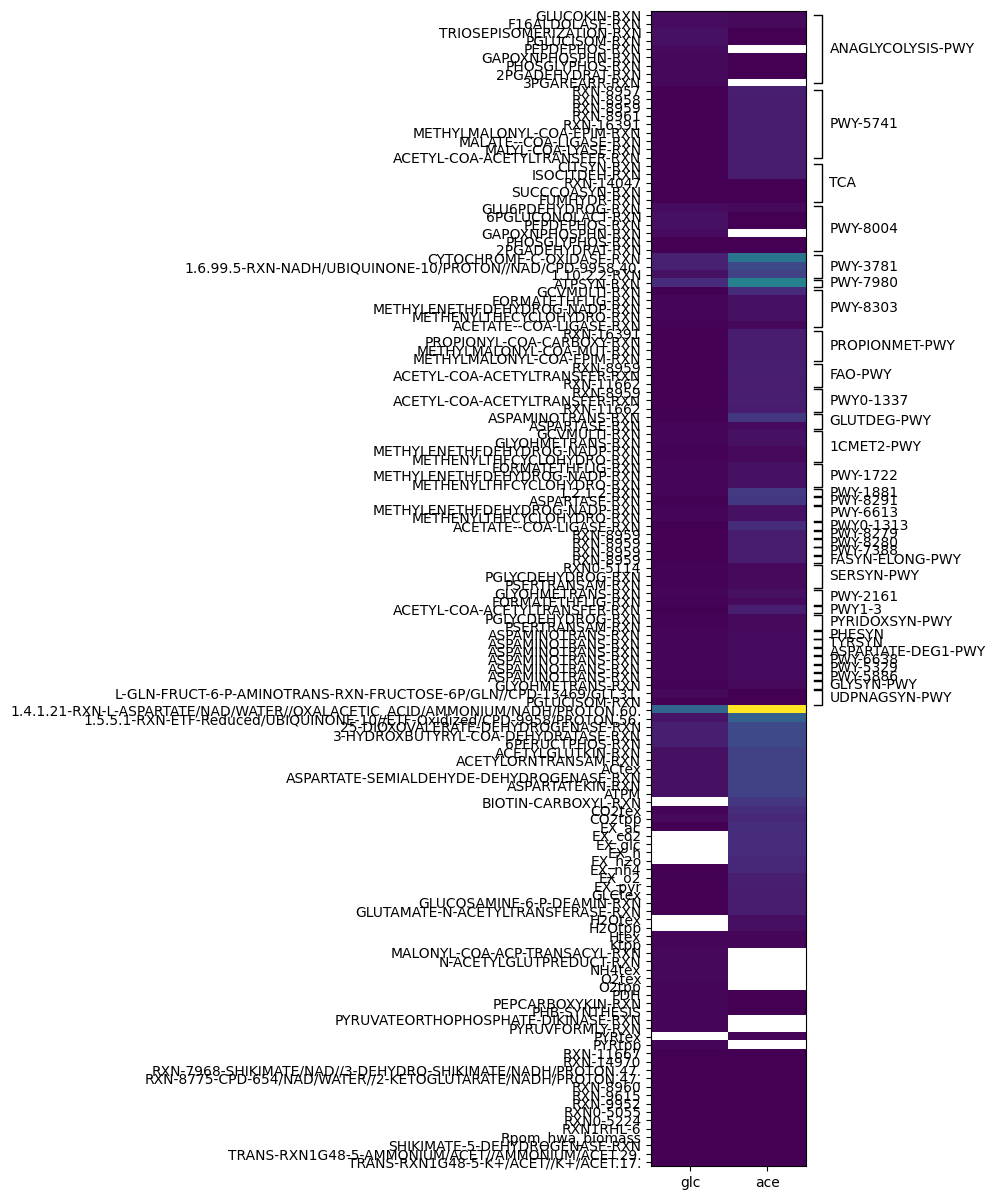

In [13]:
# Merge glc_fluxes and ace_fluxes into a dataframe
plot_fluxes = pd.DataFrame({"glc": glc_fluxes, "ace": ace_fluxes})

# Filter reactions that always have zero flux, and set remaining zeros to NaN
plot_fluxes = plot_fluxes[(plot_fluxes != 0).any(axis=1)]
plot_fluxes = plot_fluxes.replace(0, np.nan)
# plot_fluxes = plot_fluxes[np.any(plot_fluxes != 0, axis=1)]

# Take absolute values, and sort by total flux
plot_fluxes = plot_fluxes.abs()
plot_fluxes["total"] = plot_fluxes.sum(axis=1)
plot_fluxes = plot_fluxes.sort_values("total")
plot_fluxes = plot_fluxes.drop("total", axis=1)

# Filter to select top 100 fluxes
plot_fluxes = plot_fluxes[-100:]
plot_fluxes += 1e-6
f_min = plot_fluxes.min().min()
f_max = plot_fluxes.max().max()

# Plot the fluxes!! =============================================================================================
OFFSET = 0.1
SHOW_RXN_NAMES = True
cmap="viridis"

fig, ax = plt.subplots()

# First, plot fluxes from pathways of interest separately
yticks = []
plotted_reactions = set()
pos = 0
for pathway in pathways_of_interest:
    
    # Pull out the reactions in the pathway
    rxns_in_pwy = []
    for rxn in plot_fluxes.index:
        pwys = model.reactions.get_by_id(rxn).annotation.get("pathways", [])
        if isinstance(pwys, str):
            pwys = [pwys]
        
        if pathway in pwys:
            rxns_in_pwy.append(rxn)
    
    # Plot the fluxes
    ax.imshow(plot_fluxes.loc[rxns_in_pwy],
              cmap=cmap,
              aspect="auto",
              extent=(0, 2, pos, pos + len(rxns_in_pwy)),
              interpolation="none",
              vmin=f_min,
              vmax=f_max)
            #   norm="log")
    
    # Label the pathway
    vbracket(ax, 2 + OFFSET, OFFSET, OFFSET, pos + len(rxns_in_pwy) / 2, 0.9 * len(rxns_in_pwy), text=pathway)

    pos += len(rxns_in_pwy)
    yticks.extend(rxns_in_pwy)
    plotted_reactions |= set(rxns_in_pwy)

# Then, plot the rest
mappable = ax.imshow(plot_fluxes.drop(list(plotted_reactions)),
          cmap=cmap,
          aspect="auto",
          extent=(0, 2, pos, pos + len(plot_fluxes) - len(plotted_reactions)),
          interpolation="none",
          vmin=f_min,
          vmax=f_max)
        #   norm="log")
yticks.extend(plot_fluxes.index.difference(plotted_reactions))

ax.set_xticks([0.5, 1.5], ["glc", "ace"])
if SHOW_RXN_NAMES:
    ax.set_yticks(0.5 + np.arange(len(yticks)), yticks)
else:
    ax.set_yticks([])
ax.set_ylim(0, pos + len(plot_fluxes) - len(plotted_reactions))
ax.invert_yaxis()
# fig.colorbar(mappable, location="left")

fig.tight_layout()
fig.set_size_inches(2,15)

In [17]:
for rxn in [rxn for rxn in model.reactions if "PYRUVDEHYD-PWY" in rxn.annotation.get("pathways", [])]:
    print(rxn)

RXN-12583: PROTON[c] + PYRUVATE[c] + THIAMINE-PYROPHOSPHATE[c] --> 2-ALPHA-HYDROXYETHYL-THPP[c] + CARBON-DIOXIDE[c]
RXN-8629: DIHYDROLIPOYL-GCVH[c] + NAD[c] <=> NADH[c] + PROTEIN-LIPOYLLYSINE[c] + PROTON[c]
RXN0-1134: PROTON[c] + PYRUVATE[c] + Pyruvate-dehydrogenase-lipoate[c] --> CARBON-DIOXIDE[c] + Pyruvate-dehydrogenase-acetylDHlipoyl[c]
RXN0-1133: CO-A[c] + Pyruvate-dehydrogenase-acetylDHlipoyl[c] --> ACETYL-COA[c] + Pyruvate-dehydrogenase-dihydrolipoate[c]
RXN0-1132: NAD[c] + Pyruvate-dehydrogenase-dihydrolipoate[c] --> NADH[c] + PROTON[c] + Pyruvate-dehydrogenase-lipoate[c]


In [9]:
model.reactions.get_by_id("6PFRUCTPHOS-RXN").annotation

# Should be in glycolysis - why is it missing?

{'EC Number': '2.7.1.11', 'Kegg ID': 'R00756', 'stem': '6PFRUCTPHOS-RXN'}

In [10]:
# Sort pathways by total flux
pathway_fluxes = {}
for rxn in plot_fluxes.index:
    pwys = model.reactions.get_by_id(rxn).annotation.get("pathways", [])
    if isinstance(pwys, str):
        pwys = [pwys]

    for pwy in pwys:
        if pwy not in pathway_fluxes:
            pathway_fluxes[pwy] = 0
        pathway_fluxes[pwy] += plot_fluxes.loc[rxn].sum()

df = pd.DataFrame({"flux": pathway_fluxes})
df.sort_values("flux", ascending=False).head(50)

,flux
PWY-3781,616.712669
PWY-7279,616.712669
PWY-5741,449.282605
PWY-7980,343.413148
GLUCONEO-PWY,264.853732
PWY-8303,210.198830
ANAGLYCOLYSIS-PWY,201.233865
PROPIONMET-PWY,198.852283
FAO-PWY,152.863796
PWY0-1337,152.863796


In [11]:
PWY-3781  # aerobic respiration I (cytochrome c)
PWY-5741  # Ethylmalonyl-CoA pathway
PWY-7980  # ATP biosynthesis
PWY-8303  # reductive glycine pathway of autotrophic CO2 fixation
ANAGLYCOLYSIS-PWY  # Glycolysis
PROPIONMET-PWY  # propanoyl CoA degradation I
FAO-PWY  # fatty acid β-oxidation I (generic)
PWY0-1337  # oleate β-oxidation
GLUTDEG-PWY  # L-glutamate degradation II
1CMET2-PWY	# folate transformations III (E. coli)
PWY-1722  # formate assimilation into 5,10-methylenetetrahydrofolate
PWY-8004  # Entner-Doudoroff pathway I
PWY-1881  # formate oxidation to CO2
TCA
PWY-8291  # L-aspartate degradation II (aerobic)
PWY-6613  # tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate
PWY0-1313  # acetate conversion to acetyl-CoA
PWY-8279  # palmitate biosynthesis III
PWY-8280  # stearate biosynthesis IV  (likely dupe of above)
PWY-7388  # octanoyl-[acyl-carrier protein] biosynthesis (mitochondria, yeast)
FASYN-ELONG-PWY  # fatty acid elongation -- saturated
SERSYN-PWY  # L-serine biosynthesis I
PWY-2161  # folate polyglutamylation
PWY1-3  # polyhydroxybutanoate biosynthesis
PYRIDOXSYN-PWY  # pyridoxal 5'-phosphate biosynthesis I
PHESYN  # L-phenylalanine biosynthesis I
TYRSYN  # L-tyrosine biosynthesis I
ASPARTATE-DEG1-PWY  # L-aspartate degradation I
PWY-6638  # sulfolactate degradation III
PWY-5329  # L-cysteine degradation III
PWY-5886  # 3-(4-hydroxyphenyl)pyruvate biosynthesis
GLYSYN-PWY  # glycine biosynthesis I
UDPNAGSYN-PWY  # UDP-N-acetyl-D-glucosamine biosynthesis I

# All below probably identical
PWY-5971  # palmitate biosynthesis II (type II fatty acid synthase)
PWY-6282  # palmitoleate biosynthesis I (from (5Z)-dodec-5-enoate)
PWY0-862   # (5Z)-dodecenoate biosynthesis I 
PWY-7664  # oleate biosynthesis IV (anaerobic)
PWY-7663  # gondoa biosynthesis (anaerobic)
PWY-8203  # 8-amino-7-oxononanoate biosynthesis IV 	
PWY-6163  # chorismate biosynthesis from 3-dehydroquinate

# Probably RXN0-5055?
PWY-4381  # fatty acid biosynthesis initiation (type II)
PWY0-1264  # biotin-carboxyl carrier protein assembly

SyntaxError: invalid decimal literal (265365928.py, line 10)

In [ ]:
model.reactions.get_by_id("GLYOHMETRANS-RXN")

Reaction identifier,GLYOHMETRANS-RXN
Name,GLYOHMETRANS-RXN
Memory address,0x7f867cc3fa40
Stoichiometry,"SER[c] + THF-GLU-N[c] <=> GLY[c] + METHYLENE-THF-GLU-N[c] + WATER[c] L-serine + a tetrahydrofolate <=> glycine + a 5,10-methylenetetrahydrofolate + H2O"
GPR,G1G48-3584 or G1G48-1604 or G1G48-2988
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
plot_fluxes.loc["GLYOHMETRANS-RXN"]

glc     5.846592
ace    14.333070
Name: GLYOHMETRANS-RXN, dtype: float64